In [1]:
import numpy as np
import yaml

### funtional Fragments

In [2]:
# read parquet files' meta

import os
import pandas as pd
import yaml
import pyarrow.parquet as pq

config = yaml.safe_load(open("config/config.yaml"))

per_year_outputs_path = config["per_year_outputs_path"]
parquet_files = [f for f in os.listdir(per_year_outputs_path) if f.endswith('.parquet')]
print("parquet file lists: ", parquet_files)

read_file_path = os.path.join(per_year_outputs_path, parquet_files[0])
print("read: ", read_file_path)

input("press enter to read the selected parquet file meta...")

parquet_file = pq.ParquetFile(read_file_path)
num_rows = parquet_file.metadata.num_rows
num_columns = parquet_file.metadata.num_columns
column_names = parquet_file.schema.names

print(f"文件包含 {num_rows} 行, {num_columns} 列")
print("列名：", column_names)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/jebediahc/OneDrive/鱼丸车仔/TUM-before-arrival/Project Earth Observation Data Analysis/Project-files-Soil-Moisture/per_year_outputs/'

In [3]:
# read nc and virtualize test
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_dataset("data/2020-1.nc")

print(ds)

variable_name = "swvl1"
time_str = "2020-01-15T12:00"


data = ds[variable_name].sel(valid_time=time_str)  # 选择某个时间点
lat = ds.latitude
lon = ds.longitude

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.pcolormesh(lon, lat, data, cmap='YlGnBu', shading='auto')

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title(f"{variable_name} at time {time_str}")
plt.colorbar(im, orientation='vertical', label=variable_name)
plt.tight_layout()
plt.show()


Matplotlib is building the font cache; this may take a moment.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cecilia/Desktop/tum-cwt/soil-moisture-prediction-dl/data/2020-1.nc'

In [3]:
from src.preprocess import run_preprocessing
run_preprocessing()

preprocessing run


Data for 2020-01-15 downloaded successfully.
Preprocessing data from data/raw to data/processed...
Data preprocessing completed. Processed data saved to data/processed.
Visualizing data...
<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 744, latitude: 371, longitude: 701)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-01-01 ... 2020-01-31T23:...
  * latitude    (latitude) float64 3kB 72.0 71.9 71.8 71.7 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 6kB -25.0 -24.9 -24.8 ... 44.8 44.9 45.0
    expver      (valid_time) <U4 12kB ...
Data variables:
    swvl1       (valid_time, latitude, longitude) float32 774MB ...
    ro          (valid_time, latitude, longitude) float32 774MB ...
    e           (valid_time, latitude, longitude) float32 774MB ...
    tp          (valid_time, latitude, longitude) float32 774MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Wea

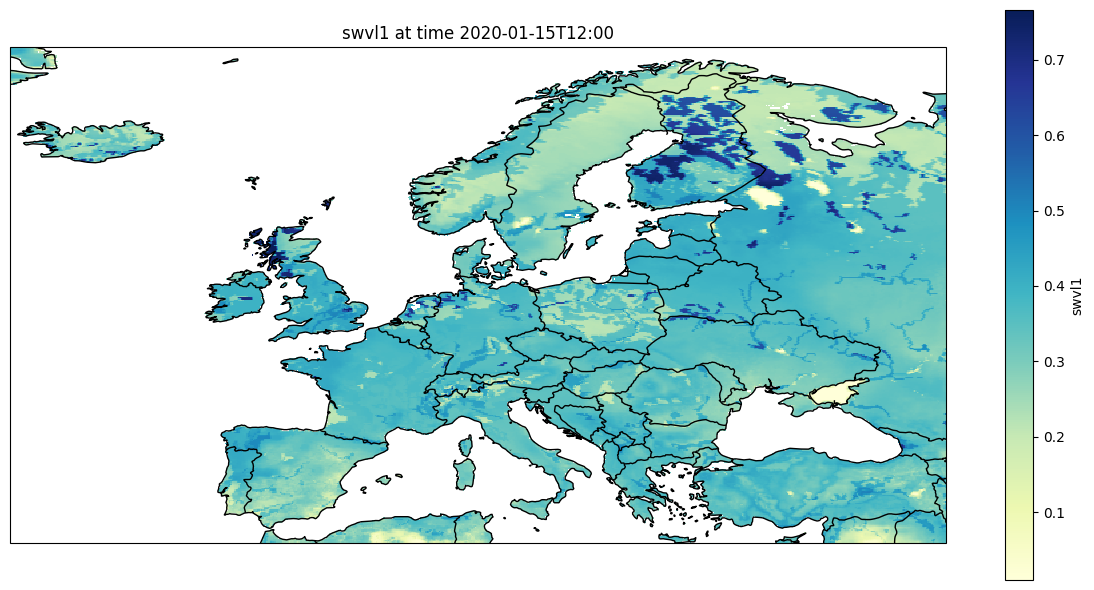

Visualization completed.
Loading model from ...
Using empty model as placeholder.
Model loaded successfully.
Running evaluation...
Evaluation Metrics:
RMSE: 0.01857
R²  : 0.95775
MAE : 0.00959
MSE : 0.00034


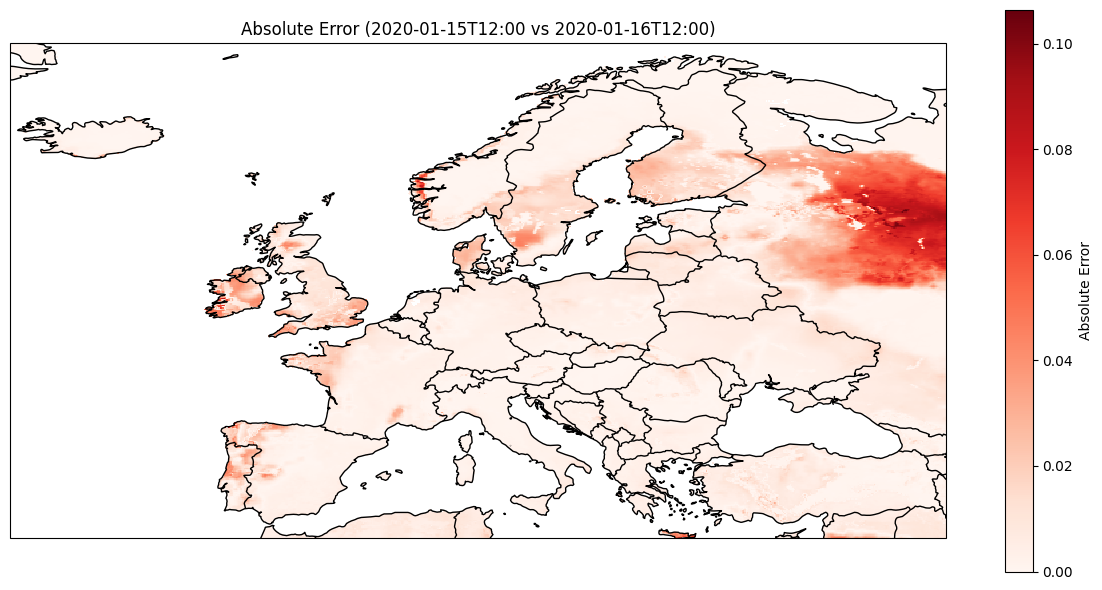

Running sequence evaluation from 2020-01-15T12:00 over 11 days...
2020-01-16 => R²: 0.9997, MAE: 0.0008
2020-01-17 => R²: 0.9991, MAE: 0.0014
2020-01-18 => R²: 0.9983, MAE: 0.0019
2020-01-19 => R²: 0.9973, MAE: 0.0024
2020-01-20 => R²: 0.9962, MAE: 0.0029
2020-01-21 => R²: 0.9948, MAE: 0.0034
2020-01-22 => R²: 0.9929, MAE: 0.0039
2020-01-23 => R²: 0.9905, MAE: 0.0044
2020-01-24 => R²: 0.9879, MAE: 0.0049
2020-01-25 => R²: 0.9850, MAE: 0.0055


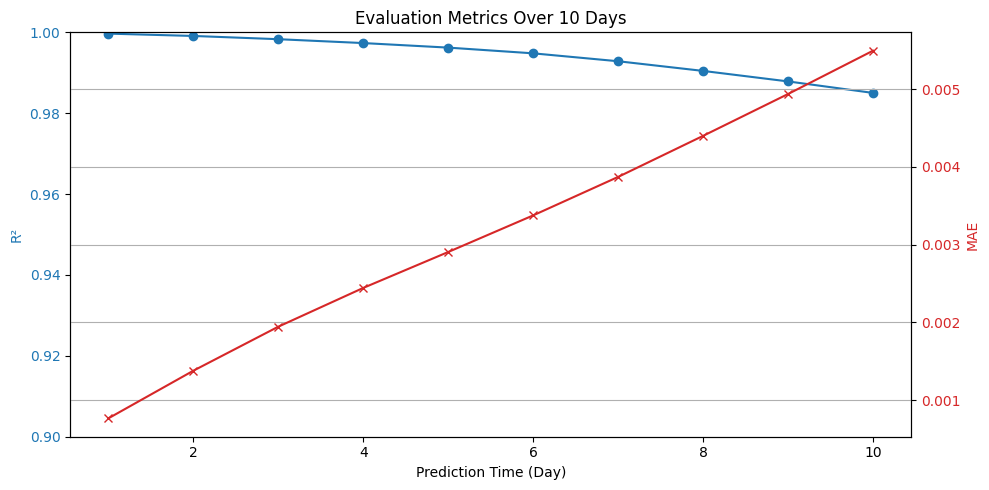

Evaluation completed.


In [1]:
# main file developing

import sys, os
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src import download, preprocess, evaluate, predict, visualize, load_model

download.download()
preprocess.run_preprocessing()
visualize.visualize_data()
load_model.load_model("")
predict.run_prediction("","")
evaluate.run_evaluation()


### traning and predic

In [4]:
# training and predict - 1 - read data
import xarray as xr
import numpy as np

lat = None
lon = None

def get_daily_mean_array(nc_path):
    ds = xr.open_dataset(nc_path)
    global lat, lon
    lat = ds.latitude
    lon = ds.longitude
  
    vars_array = np.stack([
        ds['swvl1'].values,   # (hours, lat, lon)
        ds['ro'].values,
        ds['e'].values,
        ds['tp'].values
    ], axis=-1)  # (hours, lat, lon, 4)

    total_hours = vars_array.shape[0]
    days = total_hours // 24
    vars_array = vars_array[:days*24]  # 只保留完整天数
    vars_array = vars_array.reshape(days, 24, *vars_array.shape[1:])  # (days, 24, lat, lon, 4)
    daily_mean = vars_array.mean(axis=1)  # (days, lat, lon, 4)
    # 转到 (lat, lon, days, 4)
    daily_mean = np.transpose(daily_mean, (1, 2, 0, 3))
    return daily_mean  # shape: (lat, lon, days, 4)

# 处理第一个月
arr1 = get_daily_mean_array("data/raw/2020-1.nc")
# 处理第二个月
arr2 = get_daily_mean_array("data/raw/2020-7.nc")

# 按天拼接
final_array = np.concatenate([arr1, arr2], axis=2)  # (lat, lon, days总数, 4)

print(final_array.shape)
print(lat, lon)

(371, 701, 62, 4)
<xarray.DataArray 'latitude' (latitude: 371)> Size: 3kB
array([72. , 71.9, 71.8, ..., 35.2, 35.1, 35. ], shape=(371,))
Coordinates:
    number    int64 8B ...
  * latitude  (latitude) float64 3kB 72.0 71.9 71.8 71.7 ... 35.3 35.2 35.1 35.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing <xarray.DataArray 'longitude' (longitude: 701)> Size: 6kB
array([-25. , -24.9, -24.8, ...,  44.8,  44.9,  45. ], shape=(701,))
Coordinates:
    number     int64 8B ...
  * longitude  (longitude) float64 6kB -25.0 -24.9 -24.8 ... 44.8 44.9 45.0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude


/Users/cecilia/anaconda3/envs/soil/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/cecilia/anaconda3/envs/soil/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


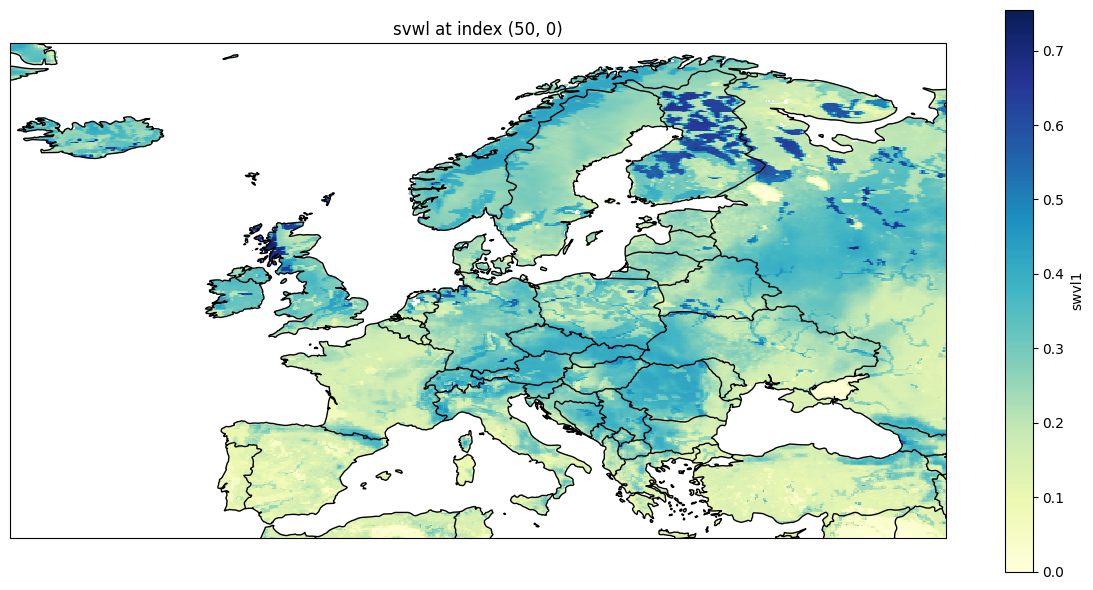

In [5]:
## training and predict 1.5 - visual
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
day_time = 50
var_i = 0  # 选择第一个变量 swvl1
plt.figure(figsize=(12, 6))
# lat = np.linspace(-90, 90, final_array.shape[0])
# lon = np.linspace(-180, 180, final_array.shape[1])
data = final_array[:, :, day_time, var_i]  # 选择第day_time天和第var_i个变量
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.pcolormesh(lon, lat, data, cmap='YlGnBu', shading='auto')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title(f"svwl at index {day_time, var_i}")
plt.colorbar(im, orientation='vertical', label="swvl1")
plt.tight_layout()
plt.show()



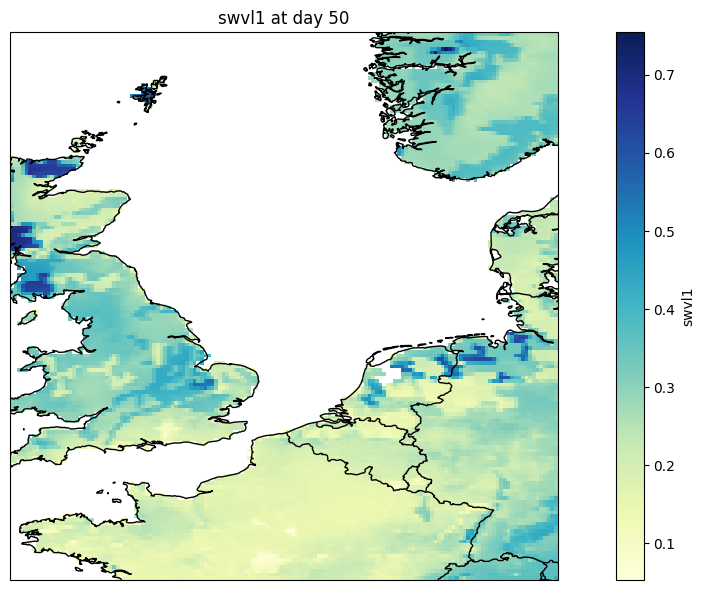

In [ ]:
## training and predict - 2 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Load your data
data = final_array
# # Normalize for stability (optional)
# data = (data - np.mean(data)) / np.std(data) # some problem causing NaN values, so we skip normalization for now

# Use a small crop for prototyping
data = data[200:250, 300:350, :, :]  # shape now (50, 50, 62, 4)
# Transpose to match model (T, C, H, W)
data = np.transpose(data, (2, 3, 0, 1))  # shape: (62, 4, 50, 50)

### Visualize the cropped part of data on map
day_time = 50  # Select a specific day
var_i = 0  # Select the first variable (swvl1)
visual_data = data[day_time, var_i, :, :]  # Extract data for the selected day and variable

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.pcolormesh(lon[300:350], lat[200:250], visual_data, cmap='YlGnBu', shading='auto')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title(f"swvl1 at day {day_time}")
plt.colorbar(im, orientation='vertical', label="swvl1")
plt.tight_layout()
plt.show()

In [27]:
visual_data

array([[0.25784555, 0.2633883 , 0.26532683, ..., 0.32359505, 0.3145485 ,
        0.29930115],
       [0.40281805, 0.2561156 , 0.23836835, ..., 0.3287735 , 0.32504973,
        0.32129416],
       [0.340168  , 0.2653993 , 0.26197624, ..., 0.32821783, 0.32689857,
        0.3236599 ],
       ...,
       [0.14166641, 0.15962982, 0.15872066, ..., 0.36335182, 0.3651619 ,
        0.36670113],
       [0.15757115, 0.15092278, 0.15068817, ..., 0.3686072 , 0.3677864 ,
        0.37291718],
       [0.15403683, 0.1586984 , 0.14556758, ..., 0.3692023 , 0.36751303,
        0.42434946]], shape=(50, 50), dtype=float32)

In [34]:
# training and predict - 3 - define dataset

class SoilMoistureDataset(Dataset):
    def __init__(self, data, input_len=20, pred_len=10):
        self.data = data
        self.input_len = input_len
        self.pred_len = pred_len

    def __len__(self):
        return self.data.shape[0] - self.input_len - self.pred_len

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_len]
        y = self.data[idx + self.input_len:idx + self.input_len + self.pred_len, 0:1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# training and predict - 4 - define model
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_out, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        self.cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size)
        self.output_layer = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, input_seq):
        b, t, c, h, w = input_seq.size()
        h_t = torch.zeros((b, 32, h, w), device=input_seq.device)
        c_t = torch.zeros((b, 32, h, w), device=input_seq.device)

        for time in range(t):
            h_t, c_t = self.cell(input_seq[:, time], h_t, c_t)

        output = self.output_layer(h_t)  # predict next step
        return output.unsqueeze(1).repeat(1, 10, 1, 1, 1)  # repeat for 10 days


In [ ]:
# training and predict - 5 - train model and evaluate

dataset = SoilMoistureDataset(data, input_len=20, pred_len=10)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(input_dim=4, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):  # use small epochs for prototyping
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: nan


KeyboardInterrupt: 

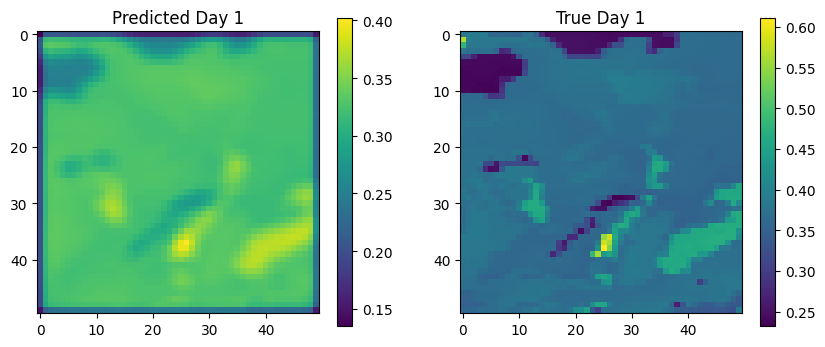

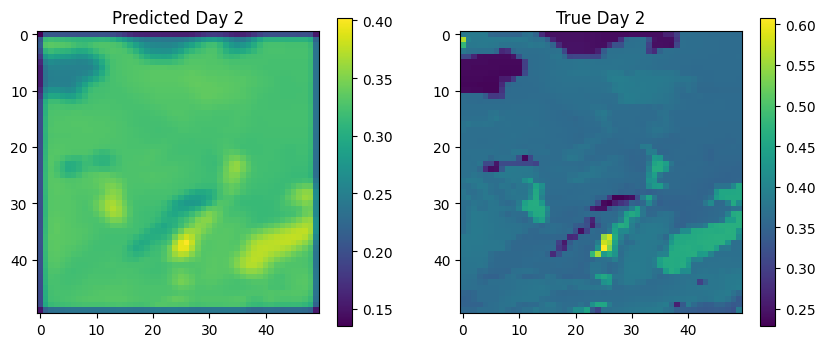

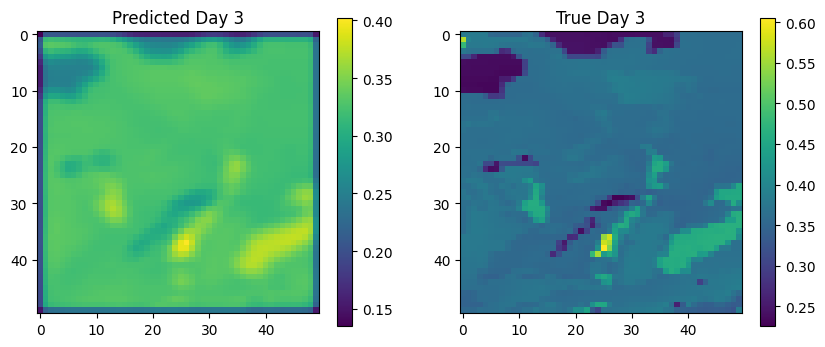

In [35]:
## training and predict - 5 - predict
model.eval()
with torch.no_grad():
    x, y = dataset[0]
    x = x.unsqueeze(0).to(device)  # batch = 1
    pred = model(x).cpu().numpy()

# Visualize prediction and ground truth for 3 days
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Predicted Day {i+1}")
    plt.imshow(pred[0, i, 0], cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title(f"True Day {i+1}")
    plt.imshow(y[i, 0], cmap='viridis')
    plt.colorbar()
    plt.show()

In [ ]:
# handy calculator
30*24

720